# Deep Hedging AI
### Convergence to Black & Scholes Delta
#### Base case: BS with (statistical) drift 0.1, cvar@1, 400 epochs, zero cost, 50000 path
#### This file: no drift, exp2 utility

Hans Buehler, January 2nd, 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)


SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello  ... Tensorflow version 2.7.1 running on 1 CPUs and 0 GPUs


2023-01-06 22:50:10.290055: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-06 22:50:10.290119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-44-231.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist


## Deep Hedging in a Black \& Scholes World

2023-01-06 22:50:11.409369: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 22:50:14.153704: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


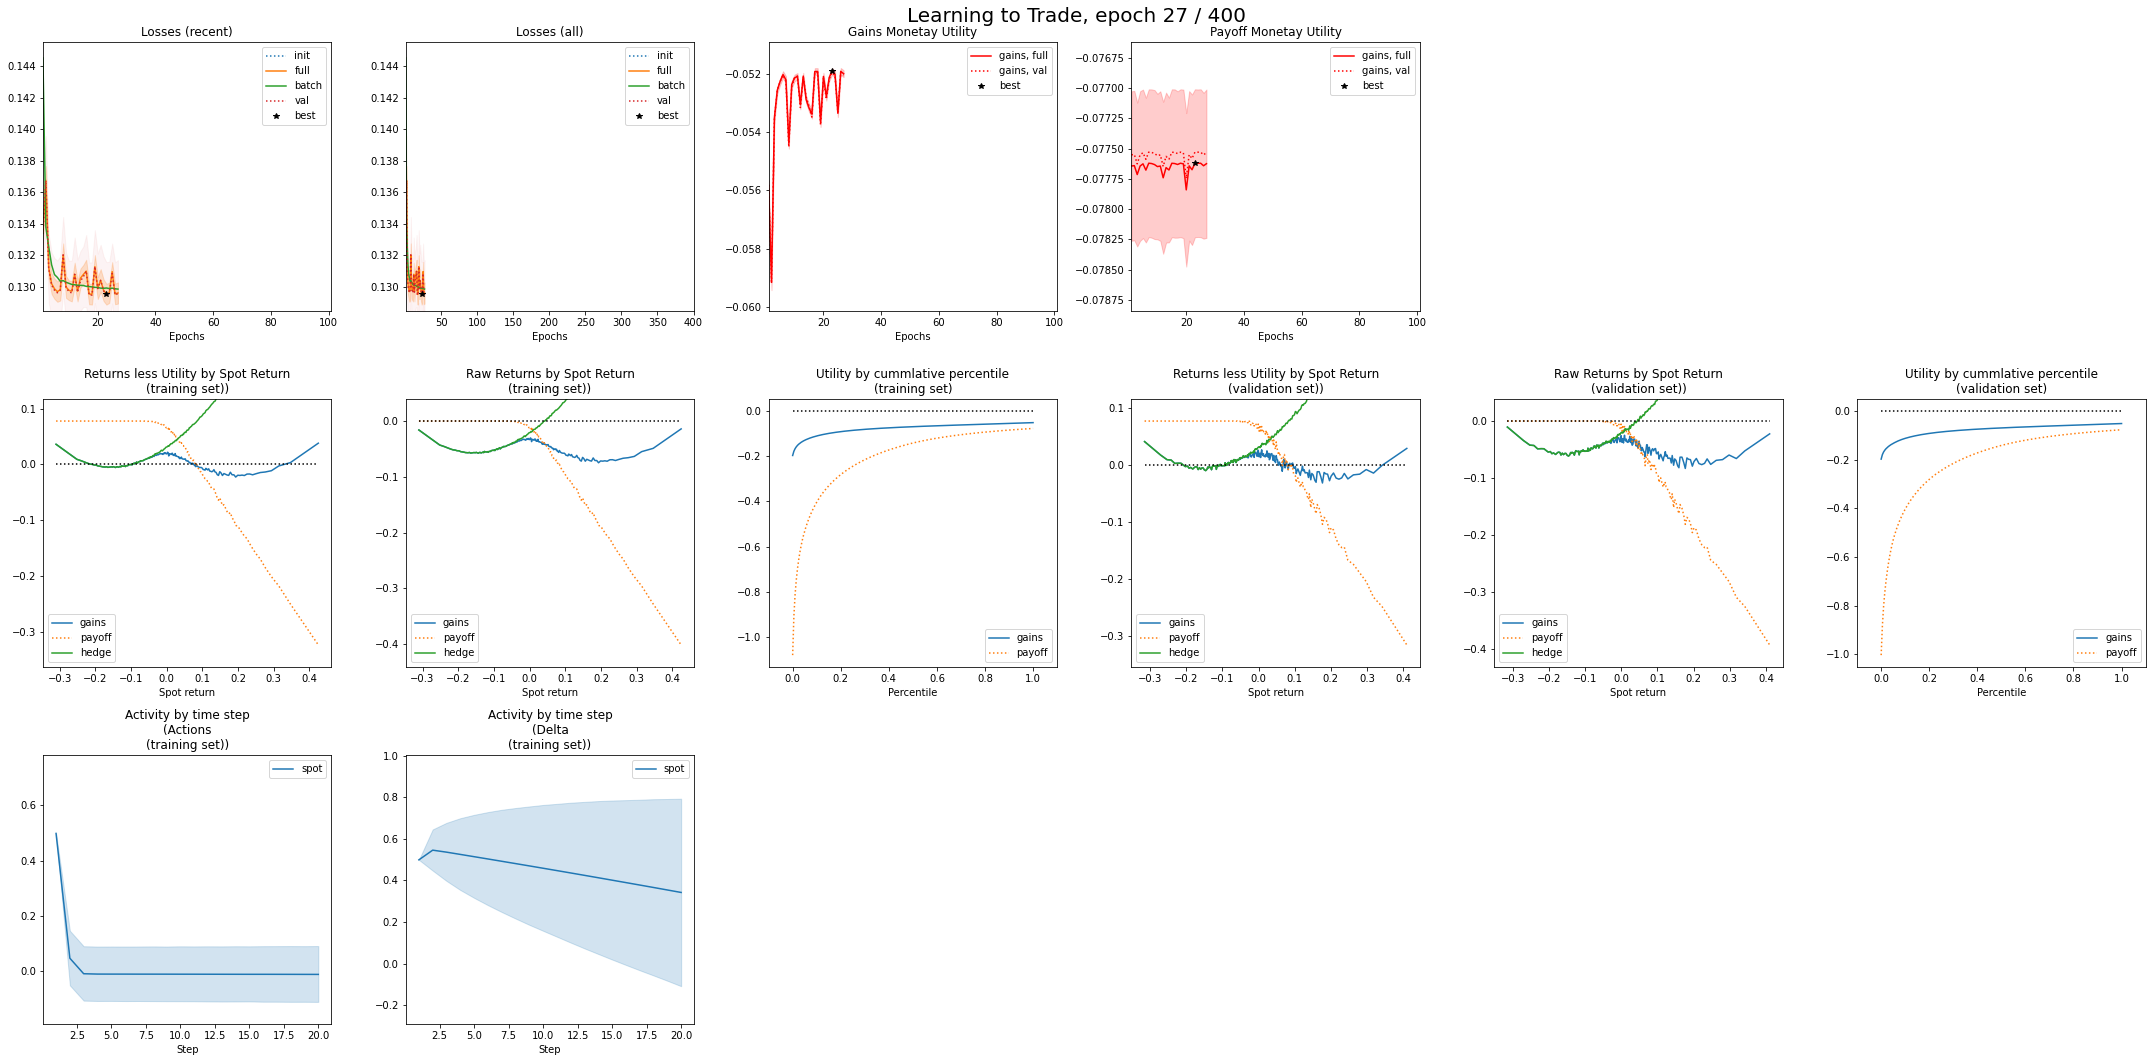

Training 27/400 epochs; 50000 samples; 5000 validation samples batch size 32 | initial loss 4.0481 (0.044282), full 0.12962 (0.000673067), best 0.129539 (0.044282), batch 0.129866, val 0.129577 (0.00212465). Best epoch 22 | time elapsed 14:56; time per epoch 33s; estimated time remaining 3:27:01                          

In [ ]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 50000
config.world.steps = 20
config.world.black_scholes = True
config.world.rvol = 0.2    # 20% volatility
config.world.drift = 0.   # real life drift
config.world.cost_s = 0.
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 40
config.gym.agent.network.activation = "softplus"
# trainer
#config.trainer.train.optimizer = "adam"
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world & validation world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=config.world("samples")//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [ ]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

display(Markdown("## Hedging results in detail"))
plot_bs_hedge.plot_blackscholes( world, gym, config )
